<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/tensorflow/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd

In [ ]:
datasize = 20000

x = tf.linspace(0,1,datasize)
x = tf.cast(x, tf.float32)
# cretaion of a row array
x = tf.reshape(x, shape = [x.shape[0],1])

In [ ]:
def f(x):
  y = x**3 + x**2 + x + 1
  return y

y = f(x) + tf.random.normal([datasize, 1], mean = 0, stddev=0.1, seed = tf.random.set_seed(1))

In [ ]:
tf.range(10)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>

In [ ]:
class InputLayer(tf.Module):

  def __init__(self, batch_size, train_perc = 0.8, seed = 1):
    self.batch_size = batch_size
    self.train_perc = train_perc
    self.seed = tf.random.set_seed(seed)

  def get_std_mean(self,x,y):

      std_x = tf.math.sqrt(tf.math.reduce_variance(x))
      mean_x = tf.math.reduce_mean(x)

      std_y = tf.math.sqrt(tf.math.reduce_variance(y))
      mean_y = tf.math.reduce_mean(y)

      return std_x, mean_x, std_y, mean_y

  def normalize(self, x ,y, std_x, mean_x, std_y, mean_y):
      return (x - mean_x)/std_x, (y - mean_y)/std_y

  def transform_range(self, x):
    x_min = tf.math.minimum(x)
    x_max = tf.math.maximum(x)
    return (x - x_min)/(x_max - x_min)


  def __call__(self, x, y):

    samples_size = y.shape[0]
    train_size = int(self.train_perc * samples_size)

    # shuffling
    indices = tf.range(samples_size)
    shuffled_indices = tf.random.shuffle(indices)
    x = tf.gather(x, shuffled_indices)
    y = tf.gather(y, shuffled_indices)


    x_train, y_train = x[:train_size,:] , y[:train_size, :]
    x_val, y_val = x[train_size:, :], y[train_size:, :]

    std_x, mean_x, std_y, mean_y  = self.get_std_mean(x_train,y_train)
    x_train, y_train= self.normalize(x_train, y_train, std_x, mean_x, std_y, mean_y)
    x_val, y_val= self.normalize(x_val, y_val, std_x, mean_x, std_y, mean_y)


    train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))

    train_dataset = train_dataset.batch(self.batch_size)

    return train_dataset, x_val, y_val, std_x, mean_x, std_y, mean_y, x_train, y_train


In [ ]:
class NNLayer(tf.Module):
  def __init__(self, number_units, input_shape, activation='sigmoid', seed = None):

    self.activation = activation
    self.seed = tf.random.set_seed(seed)

    self.W = tf.Variable(tf.random.normal(shape = [input_shape, number_units], seed = self.seed), name='W')*tf.sqrt(2./input_shape)
    self.b = tf.Variable(tf.random.normal(shape = [1, number_units], seed = self.seed),  name='b')

    if self.activation ==  'parelu':
      self.a = tf.Variable(tf.random.normal(shape = [1], seed = self.seed))

  def activation_function(self, x ):
    if self.activation == 'sigmoid':
      return 1 / (1 + tf.math.exp(-x))
    elif self.activation == 'linear':
      return x
    elif self.activation == 'relu':
      return tf.math.maximum(0,x)
    elif self.activation == 'tanh':
      return tf.math.tanh(x)
    elif self.activation == 'parelu':
      return tf.math.maximum(0.,x) + tf.math.minimum(0., self.a * x)

  def __call__(self, x):
    return self.activation_function(tf.matmul(x, self.W) + self.b)

In [ ]:
class Model(tf.Module):

  def __init__(self, n_layers, n_units, output_size=1, seed =None):

    super(Model, self).__init__()
    self.n_layers = n_layers
    self.n_units = n_units
    self.output_size = output_size
    self.seed = seed
    self.layer_input = NNLayer(self.n_units, 1, activation = 'parelu', seed = self.seed)
    self.intermediate_layer = NNLayer(self.n_units, self.n_units, activation = 'parelu', seed = self.seed)
    self.layer_output = NNLayer(self.output_size, self.n_units, activation='linear', seed = self.seed)


  @tf.function
  def __call__(self, inputs):


    globals()[f"a_{1}"] = self.layer_input(inputs)

    for ii in range(2, self.n_layers):
      globals()[f"a_{ii}"] = self.intermediate_layer(globals()[f"a_{ii - 1}"])


    return self.layer_output(globals()[f"a_{self.n_layers - 1}"] )

In [ ]:
def mse_loss(y_pred, y, regularization=None, weights=None, lambd=0):

  result = tf.square(y_pred - y)
  if regularization is None:
    pass

  elif regularization == 'L2':
    reg = 0

    weights = (weight for weight in weights if 'W' in weight.name)

    for weight in weights:
      reg += tf.reduce_sum(tf.square(weight))

    result += reg + 0.5 * lambd

  elif regularization == 'L1':
    reg = 0

    weights = (weight for weight in weights if 'W' in weight.name)

    for weight in weights:
      reg += tf.reduce_sum(tf.abs(weight))

    result += reg + 0.5 * lambd

  else:
    raise ValueError(f"Regularization {regularization} not supported!")



  return tf.reduce_mean(result)

In [ ]:
def exponential_average(beta, avg, val):
  return beta * avg + (1. - beta) * val

In [ ]:
def adam_optimizer(V, S, grad, epoch, beta_1=0.9, beta_2=0.999 , epsilon=1e-08):


  V = exponential_average(beta_1, V, grad)
  S = exponential_average(beta_2, S, tf.square(grad))


  # corrected values
  corr_v = 1.0 - beta_1 ** epoch
  corr_s = 1.0 - beta_2 ** epoch

  V_corr = V / corr_v
  S_corr = S/ corr_s

  # Normalizations wits mean and std
  adv_term = V_corr / tf.math.sqrt(S_corr + epsilon)


  return adv_term, V, S

In [ ]:
batch_size = 1024
input = InputLayer(batch_size, train_perc=0.8)
train_dataset, x_val, y_val, std_x, mean_x, std_y, mean_y, x_train, y_train = input(x,y)

n_layers,n_units, output_size = 3, 8, 1
my_model = Model(n_layers, n_units,  output_size, seed = 1)

In [ ]:
for x_batch0, y_batch0 in train_dataset.take(1):
    a,b = x_batch0, y_batch0

print(my_model(a).shape)

(1024, 1)


In [ ]:
def order_data(ts, transform=True):
  original_shape = ts.shape
  result = tf.sort(tf.reshape(ts,-1))
  if transform:
    return result
  else:
    return tf.reshape(result, shape = original_shape)

In [ ]:
from matplotlib import pyplot as plt

def plot_curves(x, model, mean_x, std_x, mean_y, std_y):
  x_plot = (std_x * x) + mean_x
  x_plot = order_data(x_plot)
  f_x_plot = f(x_plot)
  y_pred = tf.sort((std_y * my_model(order_data(x, False))) + mean_y)
  plt.plot(x_plot.numpy(), f_x_plot.numpy(), data = 'truth')
  plt.plot(x_plot.numpy(), y_pred.numpy(), data = 'pred')
  plt.show()

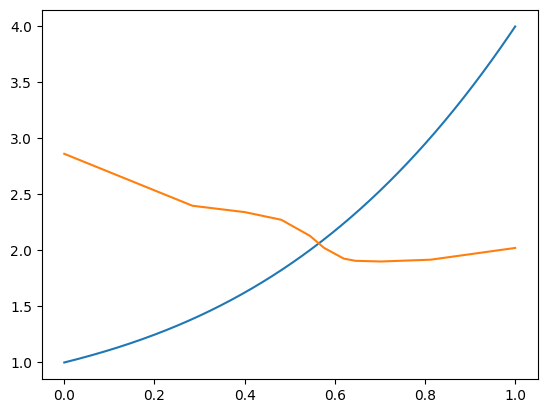

In [ ]:
plot_curves(x_train, my_model, mean_x, std_x, mean_y, std_y)

In [ ]:
!mkdir losses

mkdir: cannot create directory ‘losses’: File exists


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

def dynamic_plot_loss(train_losses,val_losses, wait_time = 0.5, scale='log'):

    # Create a figure and axes inside the loop
    fig, ax = plt.subplots()

    # Initial plot
    line_train, = ax.plot(train_losses, label = 'train')
    line_val = ax.plot(val_losses, label = 'val')

    # Update the y-data and x-data of the line
    line_train.set_ydata(train_losses)
    line_train.set_xdata(range(len(train_losses)))

    # It is necessary to rescale the axis to fit the new data
    ax.relim()
    ax.autoscale_view()

    # label
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # scale
    ax.set_xscale(scale)
    ax.set_yscale(scale)

    # legend
    ax.legend()

    # Show the plot
    plt.show()

    # Clear the current output to make room for the next plot
    clear_output(wait=True)

In [ ]:
restart = False


checkpoint = tf.train.Checkpoint(my_model)

if restart:
  epoch_0= 800
  losses = pd.read_csv(f"losses/loss_ep{epoch_0}")
  train_losses =list(losses.train_loss)
  val_losses = list(losses.val_loss)

  save_path = "checkpoints/checkpoint_ep2900-30"
  checkpoint.restore(save_path)
else:
  epoch_0 = 1
  train_losses = []
  val_losses = []

In [ ]:
V_d = []
S_d = []
for item in my_model.variables:
  shape = item.shape
  V_d.append(tf.Variable(tf.zeros(shape = shape)))
  S_d.append(tf.Variable(tf.zeros(shape = shape)))

In [ ]:
epochs = 20000
learning_rate = 1e-04
lambd = 0.0


for epoch in range(epoch_0, epochs):
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(my_model(x_batch), y_batch, regularization='L1', weights=my_model.variables, lambd=lambd)



    grads = tape.gradient(batch_loss, my_model.variables)

    idx = 0
    for g,v in zip(grads, my_model.variables):
      adv_term, V_d[idx], S_d[idx] = adam_optimizer(V_d[idx], S_d[idx], g, epoch)
      v.assign_sub(learning_rate * adv_term)
      idx += 1


  train_loss = mse_loss(my_model(x_batch), y_batch, regularization='L1', weights=my_model.variables, lambd=lambd)
  train_losses.append(float(train_loss.numpy()))

  val_loss = mse_loss(my_model(x_val), y_val, regularization='L1', weights=my_model.variables, lambd=lambd)
  val_losses.append(float(val_loss.numpy()))


  if epoch % 10 == 0:
    print(f"{epoch+1}/{epochs} TRAIN LOSS: {train_loss}, VAL LOSS: {val_loss}")

    dynamic_plot_loss(train_losses, val_losses)

  if epoch % 100 == 0:
    filename = f"saved_model/my_model_ep{epoch}"
    print(f"Saving the model at epoch {epoch}")
    loss_filename = f"losses/loss_ep{epoch}"
    checkpoint_path = f"checkpoints/checkpoint_ep{epoch}"
    save_path = checkpoint.save(checkpoint_path)


    export_losses = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})
    export_losses.to_csv(loss_filename, index_label='epoch')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-86eb08521306>", line 9, in <cell line: 0>
    batch_loss = mse_loss(my_model(x_batch), y_batch, regularization='L1', weights=my_model.variables, lambd=lambd)
                          ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 833, in __call__
    result = self._call(*args, **kwds)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 878, in _call
    results = tracing_compilation.call_

TypeError: object of type 'NoneType' has no len()

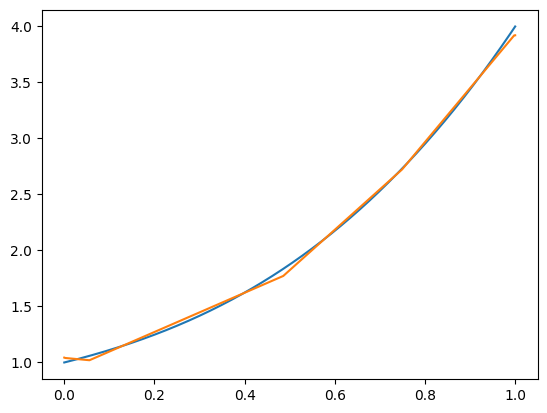

In [ ]:
plot_curves(x_train, my_model, mean_x, std_x, mean_y, std_y)

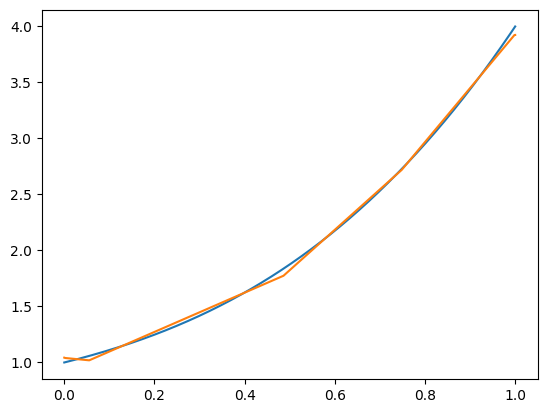

In [ ]:
plot_curves(x_val, my_model, mean_x, std_x, mean_y, std_y)

# Keras implementation

In [ ]:
import tensorflow as tf
import keras
from keras import layers

In [ ]:
initializer = 'random_normal'

keras_model = keras.Sequential(
    [
        #layers.Dense(2, activation="relu", name="layer1", kernel_initializer=initializer, bias_initializer=initializer),
        #layers.Dense(2, activation="relu", name="layer2",  kernel_initializer=initializer, bias_initializer=initializer),
        layers.Dense(2, activation="relu", name="layer3", kernel_initializer=initializer, bias_initializer=initializer),
        layers.Dense(1, activation = "linear", kernel_initializer=initializer, bias_initializer=initializer)
    ]
)
# Call model on a test input
print(keras_model(x_train).shape)


In [ ]:
from keras import losses
from keras import optimizers

loss = losses.MeanSquaredError()
optimizer = optimizers.SGD(learning_rate = 1e-04)

In [ ]:
keras_model.compile(optimizer = optimizer, loss = loss)

In [ ]:
epochs = 1000
history = keras_model.fit(train_dataset, epochs = epochs, validation_data= (x_val, y_val))

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, data = 'train')
plt.plot(val_loss, data = 'val')
plt.show()

In [ ]:
keras_model.compile?